In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

2025-03-30 15:01:50.274756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743339710.448514    2292 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743339710.497073    2292 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-30 15:01:51.826883: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Cargar el archivo CSV
df = pd.read_csv('bitcoin.csv')

# Mostrar las primeras filas del DataFrame
df.head()

,Fecha,Ultimo,Apertura,Maximo,Minimo,Vol.,% var.
0,18.02.2025,"95.638,0","95.781,5","96.645,1","93.403,4","74,09K",-0.15%
1,17.02.2025,"95.781,3","96.120,2","97.002,3","95.222,0","58,40K",-0.36%
2,16.02.2025,"96.132,1","97.573,1","97.706,5","96.060,2","33,35K",-1.48%
3,15.02.2025,"97.573,4","97.504,4","97.973,2","97.210,8","29,65K",+0.07%
4,14.02.2025,"97.504,6","96.611,6","98.817,3","96.316,5","65,37K",+0.93%


In [4]:
print(df.describe())

             Fecha Ultimo Apertura Maximo Minimo   Vol. % var.
count         4787   4787     4787   4787   4787   4787   4787
unique        4787   4311     4304   4293   4311   4316   1522
top     12.01.2012    5,1      5,1    5,1    5,1  1,05M  0,00%
freq             1     26       26     21     21      6    130


In [5]:
df.isna().sum()

Fecha       0
Ultimo      0
Apertura    0
Maximo      0
Minimo      0
Vol.        0
% var.      0
dtype: int64

In [6]:
# Replace commas with dots and convert columns to float
columns_to_convert = ['Ultimo', 'Apertura', 'Maximo', 'Minimo']
for column in columns_to_convert:
    df[column] = df[column].str.replace('.', '', regex=False).str.replace(',', '.').astype(float)

In [7]:
# Fijar la semilla para reproducibilidad
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [8]:
# Ordenar los datos por fecha
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True)
df = df.sort_values('Fecha')

In [9]:
# Ordenar los datos por fecha (si no lo están ya)
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True)
df = df.sort_values('Fecha')
print(df['Fecha'])

4786   2012-01-12
4785   2012-01-13
4784   2012-01-14
4783   2012-01-15
4782   2012-01-16
          ...    
4      2025-02-14
3      2025-02-15
2      2025-02-16
1      2025-02-17
0      2025-02-18
Name: Fecha, Length: 4787, dtype: datetime64[ns]


In [10]:
# Utilizamos solo la columna del precio de cierre
data = df['Ultimo'].values.reshape(-1,1)

In [11]:
# Escalado de datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [12]:
# Crear secuencias para el entrenamiento
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

# Probar con distintos tamaños de ventana
n_steps = 50  # itera probando distintos valoreses 
X, y = create_sequences(scaled_data, n_steps)

# Dividir en entrenamiento y test (por ejemplo, 80-20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [13]:
# Modelo Secuencial con LSTM o GRU
def build_sequential_model(model_type='LSTM', n_steps=50, n_features=1, n_units=50, n_layers=1, optimizer='rmsprop'):
    model = Sequential()
    # Agregar la primera capa con la especificación de input_shape
    if model_type == 'LSTM':
        model.add(LSTM(n_units, return_sequences=(n_layers > 1), input_shape=(n_steps, n_features)))
    elif model_type == 'GRU':
        model.add(GRU(n_units, return_sequences=(n_layers > 1), input_shape=(n_steps, n_features)))
    else:
        raise ValueError("Tipo de modelo no soportado")
    
    # Agregar capas ocultas adicionales, si se especifica
    for _ in range(n_layers - 1):
        if model_type == 'LSTM':
            model.add(LSTM(n_units, return_sequences=True))
        else:
            model.add(GRU(n_units, return_sequences=True))
        model.add(Dropout(0.2))  # opción para regularizar

    # Capa final de salida
    model.add(Dense(1))
    
    # Seleccionar optimizador
    if optimizer.lower() == 'rmsprop':
        opt = RMSprop()
    elif optimizer.lower() == 'adam':
        opt = Adam()
    else:
        raise ValueError("Optimizador no soportado")
        
    model.compile(optimizer=opt, loss='mae')
    return model

In [14]:
# Modelo Funcional con LSTM
def build_functional_model(model_type='LSTM', n_steps=50, n_features=1, n_units=50, n_layers=1, optimizer='rmsprop'):
    inputs = Input(shape=(n_steps, n_features))
    x = inputs
    # Primera capa
    if model_type == 'LSTM':
        x = LSTM(n_units, return_sequences=(n_layers > 1))(x)
    elif model_type == 'GRU':
        x = GRU(n_units, return_sequences=(n_layers > 1))(x)
    else:
        raise ValueError("Tipo de modelo no soportado")
    
    # Capas ocultas adicionales
    for _ in range(n_layers - 1):
        if model_type == 'LSTM':
            x = LSTM(n_units, return_sequences=True)(x)
        else:
            x = GRU(n_units, return_sequences=True)(x)
        x = Dropout(0.2)(x)
    
    outputs = Dense(1)(x)
    
    model = Model(inputs, outputs)
    
    # Seleccionar optimizador
    if optimizer.lower() == 'rmsprop':
        opt = RMSprop()
    elif optimizer.lower() == 'adam':
        opt = Adam()
    else:
        raise ValueError("Optimizador no soportado")
        
    model.compile(optimizer=opt, loss='mae')
    return model

W0000 00:00:1743339718.640496    2292 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/feliciano/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
MAE modelo secuencial LSTM: 0.00022881517852993926


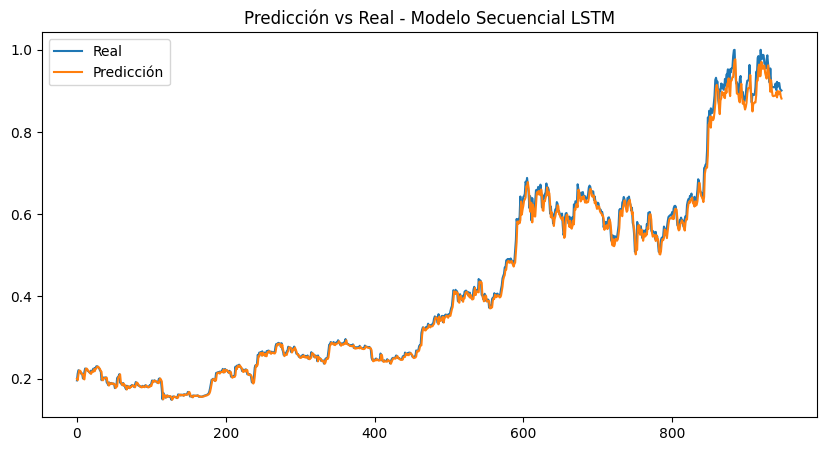

In [15]:
# Entrenamiento y evaluación de un ejemplo
# Ejemplo: modelo secuencial LSTM con 1 capa, 50 neuronas, usando RMSprop
model_seq = build_sequential_model(model_type='LSTM', n_steps=n_steps, n_features=1,
                                   n_units=50, n_layers=1, optimizer='rmsprop')
history_seq = model_seq.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=0)

# Predicción y evaluación
predictions = model_seq.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MAE modelo secuencial LSTM:", mse)

# Visualización
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Real')
plt.plot(predictions, label='Predicción')
plt.title("Predicción vs Real - Modelo Secuencial LSTM")
plt.legend()
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
MAE modelo funcional GRU: 0.00016366476610015613


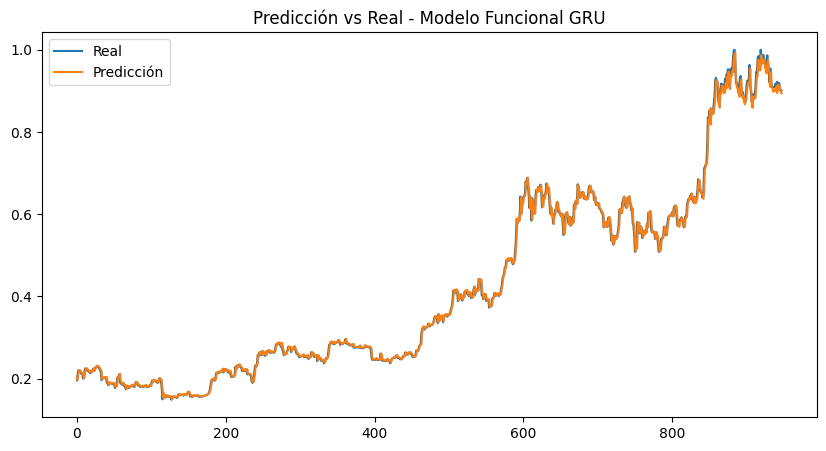

In [16]:
# Por ejemplo, construir un modelo funcional con GRU:
model_func = build_functional_model(model_type='GRU', n_steps=n_steps, n_features=1,
                                    n_units=50, n_layers=1, optimizer='adam')
history_func = model_func.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=0)

predictions_func = model_func.predict(X_test)
mse_func = mean_squared_error(y_test, predictions_func)
print("MAE modelo funcional GRU:", mse_func)

plt.figure(figsize=(10,5))
plt.plot(y_test, label='Real')
plt.plot(predictions_func, label='Predicción')
plt.title("Predicción vs Real - Modelo Funcional GRU")
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import mean_absolute_error

# Desescalar los resultados
y_test_descaled = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_descaled = scaler.inverse_transform(predictions)

# Calcular el MAE desescalado
mae_descaled = mean_absolute_error(y_test_descaled, predictions_descaled)
print("MAE desescalado del modelo LSTM:", mae_descaled)

# Mostrar los primeros 5 resultados desescalados
print("Valores reales desescalados (primeros 5):", y_test_descaled.flatten()[:5])
print("Predicciones desescaladas (primeros 5):", predictions_descaled.flatten()[:5])

MAE desescalado del modelo LSTM: 1008.5338558148736
Valores reales desescalados (primeros 5): [20785.6 22525.8 23410.2 23215.2 23153. ]
Predicciones desescaladas (primeros 5): [21166.834 20820.625 22287.842 23349.861 23290.12 ]


In [24]:
# Desescalar los resultados del modelo GRU
predictions_func_descaled = scaler.inverse_transform(predictions_func)

# Calcular el MAE desescalado para el modelo GRU
mae_func_descaled = mean_absolute_error(y_test_descaled, predictions_func_descaled)
print("MAE desescalado del modelo GRU:", mae_func_descaled)

# Mostrar los primeros 5 resultados desescalados
print("Valores reales desescalados (primeros 5):", y_test_descaled.flatten()[:5])
print("Predicciones desescaladas del modelo GRU (primeros 5):", predictions_func_descaled.flatten()[:5])

MAE desescalado del modelo GRU: 857.9154393707148
Valores reales desescalados (primeros 5): [20785.6 22525.8 23410.2 23215.2 23153. ]
Predicciones desescaladas del modelo GRU (primeros 5): [21302.59  20940.072 22531.506 23434.17  23396.373]
